# Training data inspection and cleaning

## Background

Machine learning (ML)-based crop type classification using Earth observation data provides a cost-effective solution for mapping crop types at regional to country scales. To train and validate a crop classification model, georeferenced crop labels are needed. 

In a supervised ML approach, the performance of the classification model depends on the quality and quantity of the training data used. It is important that a large number of training data are provided that accurately represent the classes of interest and captures the diversity within each crop class.


### Training data requirements

Below, a number of factors are listed to be considered when determining if a georeferenced dataset is suitable for training a crop type classification model. 
If no suitable data is available, the criterias can be used to guide data collection effort. 

**Data collection method**

In situ data, i.e. crop labels collected in the field, are commonly used because crop types can be accurately determined and the location of the crops are accurately recorded using GPS. Field campaigns are carried out during growing seasons when the different types of crops can be differentiated. Tools, such as ECAAS ODK toolkit, may be used to standardise data collection but is not required. 

**Crop labels**

Labels should include all crop types that need to be mapped. If a high-accuracy cropland extent map (crop mask) is available, only crop types identified within the crop mask is required. If not, additional minor crop types and non-crop types such as grassland should be included to support the identification of other types of land covers that need to be distinguished from the major crop types. Hierarchical legend definitions may be used, such as the nested classes adapted from the Indicative Crop Classification (ICC) recommended by the [JECAM_Guidelines](http://jecam.org/wp-content/uploads/2018/10/JECAM_Guidelines_for_Field_Data_Collection_v1_0.pdf).

**Spatial distribution**

Training data should be spatially distributed to cover areas spread across the region of interest. Spatially distributed samples ensure that diversity within crop type classes are captured. To train a model for a large region or a country, training data collected from different ecological zones are needed. Ideally, stratified random sampling is implemented, however, due to land access constraints, random sampling is hard to implement. A capture strategy may include opportunistic collection to increase number of samples.

**Data type**

Crop labels can be provided for point locations or within polygons. If point data is collected, it should be collected within a small (at least 30 m across) homogenous crop area. If a polygon is drawn for a crop type, it should cover a homogenous crop area. 

**Quantity**

Number of data points required depends on the crop types to be differentiated, diversity between and within crop types and diversity of the training data. Ideally, more than a few hundred diverse points for each class is needed. If polygons are collected, the number of polygons needed will be smaller if each polygon can be divided to cover a few distinct point locations. However, noting that quantity and spatial distribution need to be considered together to ensure diversity of the training sample.

**Attributes**

For each data point, following attributes are required: crop type label (including major and sub-classes as defined in legends), date and time of data collection, geolocation, geolocation accuracy, and spatial reference system used. Additional metadata that are helpful include those help to understand who and how the data is collected, confidence of classification, post-processing or editing carried out, and additional information about the paddocks. 

### Training data preprepation

When a georeferenced crop label dataset meets the basic requirements, it is still important to examine the data to ensure the attributes are complete and correct. Some preprocessing is often needed to clean up the data and prepare it for further use. 


## Description

In this notebook, we will examine the crop labels provided by courtesy of Mozambique National Sustainable Development Fund (FNDS). 

After inspection of the data attributes and their distributions, we have found that the sample is dominated by mixed cropping labels. Due to lack of information on the mixing ratio, we will group the data points into four classes, maize, maize, sesame, soy and other, so we can focus on mapping the major crop types. The other class includes pure and mixed cropping areas where the three major classes are not present. 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import json
import pickle
from datacube.utils import geometry
from deafrica_tools.classification import collect_training_data
from odc.io.cgroups import get_cpu_quota
from sklearn.preprocessing import LabelEncoder

from feature_collection import feature_layers

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Load training data and inspect its distribution

In [2]:
# Create data and results directories if they don't exist
input_folder="Data"
output_folder="Results"
output_crs="EPSG:32736"
if not os.path.exists(input_folder):
    os.makedirs(input_folder)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# Point to crop type training data
path= os.path.join(input_folder,"Cash_crop_type_subset_single_crops_merged.shp")

# Load input data and project
single_crops_subset = gpd.read_file(path).to_crs(output_crs)

In [4]:
# Print first few rows of the dataset
single_crops_subset.head()

,year,Crop_type,geometry
0,2021,Maize,"POLYGON ((604985.946 7872596.580, 604974.726 7..."
1,2021,Maize,"POLYGON ((605274.155 7872593.428, 605290.545 7..."
2,2021,Sesame,"POLYGON ((882127.657 8142716.654, 882121.082 8..."
3,2021,Maize,"POLYGON ((605120.772 7873840.472, 605087.585 7..."
4,2021,Maize,"POLYGON ((628117.635 7887503.320, 628124.870 7..."


### Number of Polygons

Total number of training polygons: 237


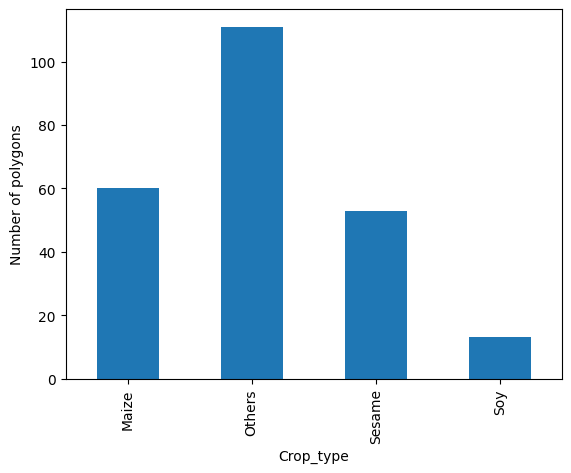

In [5]:
# Total number of points
print("Total number of training polygons:", len(single_crops_subset))

# Number of points per class
single_crops_subset.groupby("Crop_type").size().plot(kind="bar", ylabel="Number of polygons");

### Size of Polygons

Median size of the polygons (sq m): 5358.5665601928595


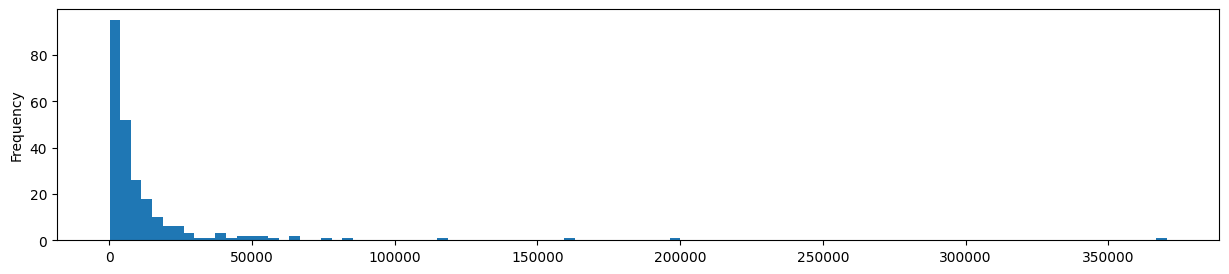

In [6]:
# Median size of the polygons
print("Median size of the polygons (sq m):", single_crops_subset.area.median())

single_crops_subset.area.plot(kind="hist", bins=100, figsize=(15,3), density=False);

> While the total number of polygons is not large, we will be able to extract multiple points within a polygon to build up a training sample.

### Spatial distribution

We will also visualize the locations of the polygons against a Google base map. It can be seen that the polygons are spread across the country. Individual polygon can be inspected by zooming in and hover the mouse over it.

In [10]:
single_crops_subset.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )

> We can also inspect the locations of specific crop classes

In [ ]:
single_crops_subset[single_crops_subset.Crop_type=='Soy'].explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )